<a href="https://colab.research.google.com/github/dennisakio/backtests-ibov-cbs-repo/blob/master/Venda_CBs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CDI.CSV to CDI.CSV
Saving Ibov.CSV to Ibov.CSV


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
start_date = '30/06/1994'  # Início Ibov: 30/06/1994
end_date = '31/07/2020'  # Dados até 06/08/2020
circuit_breakers_dates = ['05/09/1994', '27/10/1997', '07/11/1997', '12/11/1997', '21/08/1998', '04/09/1998',
                          '10/09/1998', '17/09/1998', '13/01/1999', '14/01/1999', '11/09/2001', '29/09/2008',
                          '06/10/2008', '10/10/2008', '15/10/2008', '22/10/2008', '18/05/2017', '09/03/2020',
                          '11/03/2020', '12/03/2020', '16/03/2020', '18/03/2020']
skipped_days = 21
idx_fee = 0.000  # BOVA11: 0.003
idx_tax_rate = 0.15
cdi_tax_rate = 0.225
cdi_iof = 0.3  # IOF para 21 dias
b3_fee = 0.0003068

idx_fee_daily = (1 + idx_fee) ** (1 / 252) - 1

In [ ]:
# Lê dado dos índices
import io
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
idx_data = pd.read_csv(io.BytesIO(uploaded['Ibov.csv']),
                       delimiter=';', thousands='.', decimal=',', index_col='Data',
                       parse_dates=True, date_parser=dateparse)
cdi_data = pd.read_csv(io.BytesIO(uploaded['CDI.csv']),
                       delimiter=';', decimal=',', index_col='Data',
                       parse_dates=True, date_parser=dateparse)

In [ ]:
# Datas de análise (dd/mm/yyyy)
days = pd.date_range(pd.to_datetime(start_date, format='%d/%m/%Y'), pd.to_datetime(end_date, format='%d/%m/%Y'),
                     freq='B')
months = pd.date_range(pd.to_datetime(start_date, format='%d/%m/%Y'), pd.to_datetime(end_date, format='%d/%m/%Y'),
                       freq='M')
years = pd.date_range(pd.to_datetime(start_date, format='%d/%m/%Y'), pd.to_datetime(end_date, format='%d/%m/%Y'),
                      freq='BY')
day_count = days.value_counts().sum()

In [ ]:
# Cria dataframe com os variações diárias dos índices
df_idx_day = pd.DataFrame({'Date': days})
df_idx_day.set_index('Date', inplace=True)
df_idx_day['Close'] = idx_data.Ultimo
df_idx_day['PctChange'] = df_idx_day.Close.pct_change()
df_idx_day['ReturnNoFees'] = (1 + df_idx_day.PctChange).cumprod()
df_idx_day['Return'] = (1 - idx_fee_daily) * df_idx_day.ReturnNoFees
df_idx_day['CDI_PctChange'] = cdi_data.Taxa
df_idx_day['CDI_PctChange'].fillna(0, inplace=True)
df_idx_day['CDI_Return'] = (1 + df_idx_day.CDI_PctChange).cumprod()

In [ ]:
# Dataframe com cálculos
df_calc = pd.DataFrame({'Date': days})
df_calc.set_index('Date', inplace=True)
df_calc['idxDailyReturn'] = 1 + df_idx_day.PctChange
df_calc['CDIDailyReturn'] = 1 + df_idx_day.CDI_PctChange

In [ ]:
# Datas onde houve Circuit Breakers
df_calc['isCB'] = df_calc.index.isin(pd.to_datetime(circuit_breakers_dates, format='%d/%m/%Y'))

In [ ]:
# Retorno do primeiro dia nas novas compras do índice
df_calc['NextBuyAfterCB_1stDayReturn'] = np.where(df_calc.isCB.shift(skipped_days+1),
                                                  1 + df_idx_day.PctChange, np.nan)

In [ ]:
# Calcula retorno do índice desde a última compra
aux_df = df_calc.loc[df_calc.NextBuyAfterCB_1stDayReturn.isnull(), 'idxDailyReturn'].groupby(
    df_calc.NextBuyAfterCB_1stDayReturn.notna().cumsum()).cumprod()
df_calc['idx_afterCB_CurrentReturn'] = np.where(df_calc.NextBuyAfterCB_1stDayReturn.notna(),
                                                df_calc.NextBuyAfterCB_1stDayReturn,
                                               aux_df * df_calc.NextBuyAfterCB_1stDayReturn.ffill())

In [ ]:
# Mesma coisa de cima, só que para o CDI
df_calc['CDI_1stDayReturn'] = np.where(df_calc.isCB.shift(),
                                       1 + df_idx_day.CDI_PctChange, np.nan)
aux_df = df_calc.loc[df_calc.CDI_1stDayReturn.isnull(), 'CDIDailyReturn'].groupby(
    df_calc.CDI_1stDayReturn.notna().cumsum()).cumprod()
df_calc['CDI_CurrentReturn'] = np.where(df_calc.CDI_1stDayReturn.notna(),
                                        df_calc.CDI_1stDayReturn,
                                        aux_df * df_calc.CDI_1stDayReturn.ffill())

In [ ]:
# Dias no CDI após circuit breakers
df_skipped_days_after_CB = pd.DataFrame({'Date': days})
df_skipped_days_after_CB.set_index('Date', inplace=True)
for sd in range(skipped_days):
    df_skipped_days_after_CB['Day' + str(sd + 1)] = df_calc.isCB.shift(sd + 1)
df_calc['SkippedDaysAfterCB'] = df_skipped_days_after_CB.any(axis=1)

In [ ]:
# Maldito imposto
df_calc['idx_AfterCB_Taxes'] = np.where(~df_calc.SkippedDaysAfterCB & df_calc.SkippedDaysAfterCB.shift(-1) &
                                    (df_calc.idx_afterCB_CurrentReturn > 1),
                                    1 - idx_tax_rate, 1)
df_calc['CDI_Taxes'] = np.where(df_calc.SkippedDaysAfterCB & ~df_calc.SkippedDaysAfterCB.shift(-1).fillna(True),
                                1 - cdi_tax_rate, 1)
df_calc['CDI_IOF'] = np.where(df_calc.SkippedDaysAfterCB & ~df_calc.SkippedDaysAfterCB.shift(-1).fillna(True),
                              1 - cdi_iof, 1)
df_calc['B3_Fees'] = np.where((~df_calc.SkippedDaysAfterCB & df_calc.SkippedDaysAfterCB.shift(-1) &
                               (df_calc.idx_afterCB_CurrentReturn > 1)) |
                              (~df_calc.SkippedDaysAfterCB & df_calc.SkippedDaysAfterCB.shift()),
                              1 - b3_fee, 1)

In [ ]:
# Variação percentual diária da estratégia sem taxas
df_calc['PctChange_SkipDaysAfterCB'] = np.where(df_calc.SkippedDaysAfterCB,
                                                df_idx_day.CDI_PctChange, df_idx_day.PctChange)

In [ ]:
# Variação percentual diária da estratégia com taxas
df_calc['RealPctChange_SkipDaysAfterCB'] = np.where(df_calc.SkippedDaysAfterCB,
                                                    ((1 + df_calc.PctChange_SkipDaysAfterCB) *
                                                     ((1 + (df_calc.CDI_CurrentReturn - 1) *
                                                       df_calc.CDI_IOF * df_calc.CDI_Taxes) /
                                                      df_calc.CDI_CurrentReturn) - 1),
                                                    ((1 + df_calc.PctChange_SkipDaysAfterCB) *
                                                     ((1 + (df_calc.idx_afterCB_CurrentReturn *
                                                            (1 - idx_fee_daily) * df_calc.B3_Fees - 1) *
                                                       df_calc.idx_AfterCB_Taxes) /
                                                      df_calc.idx_afterCB_CurrentReturn) - 1))

In [ ]:
# Retorno com e sem taxas
df_calc['Return_SkipDaysAfterCB'] = (1 + df_calc.RealPctChange_SkipDaysAfterCB).cumprod()
df_calc['ReturnNoTax_SkipDaysAfterCB'] = (1 + df_calc.PctChange_SkipDaysAfterCB).cumprod()

In [ ]:
# Dados Finais
num_skipped_days = df_calc['SkippedDaysAfterCB'].sum()
return_idx = df_idx_day.ReturnNoFees.iloc[-1]
return_strategy_notax = df_calc.ReturnNoTax_SkipDaysAfterCB.iloc[-1]
return_strategy = df_calc.Return_SkipDaysAfterCB.iloc[-1]
cagr_idx = df_idx_day.ReturnNoFees.iloc[-1] ** (252/day_count) - 1
cagr_strategy_notax = df_calc.ReturnNoTax_SkipDaysAfterCB.iloc[-1] ** (252/day_count) - 1
cagr_strategy = df_calc.Return_SkipDaysAfterCB.iloc[-1] ** (252/day_count) - 1
strategy_notax_pct_of_idx = return_strategy_notax / return_idx
strategy_pct_of_idx = return_strategy / return_idx
print('Total Days: %d' % day_count)
print('Skipped Days: %d' % num_skipped_days)
print('Return Index: %.2f' % return_idx)
print('Return Strategy (No Taxes): %.2f' % return_strategy_notax)
print('Return Strategy: %.2f' % return_strategy)
print('CAGR Index: %.2f%%' % (cagr_idx*100))
print('CAGR Strategy (No Taxes): %.2f%%' % (cagr_strategy_notax*100))
print('CAGR Strategy: %.2f%%' % (cagr_strategy*100))
print('Strategy (No Taxes) Return/Index: %.2f' % strategy_notax_pct_of_idx)
print('Strategy Return/Index: %.2f' % strategy_pct_of_idx)

Total Days: 6807
Skipped Days: 224
Return Index: 28.41
Return Strategy (No Taxes): 38.35
Return Strategy: 25.06
CAGR Index: 13.19%
CAGR Strategy (No Taxes): 14.45%
CAGR Strategy: 12.67%
Strategy (No Taxes) Return/Index: 1.35
Strategy Return/Index: 0.88


In [ ]:
# Gráficos
sns.set()
sns.set_style('darkgrid', {'axes.facecolor': '0.15',
                           'figure.facecolor': '0.1',
                           'grid.color': '0.1',
                           'axes.labelcolor': '.7',
                           'text.color': '.7',
                           'xtick.color': '.7',
                           'ytick.color': '.7',
                           'axes.spines.left': False,
                           'axes.spines.bottom': False,
                           'axes.spines.right': False,
                           'axes.spines.top': False})

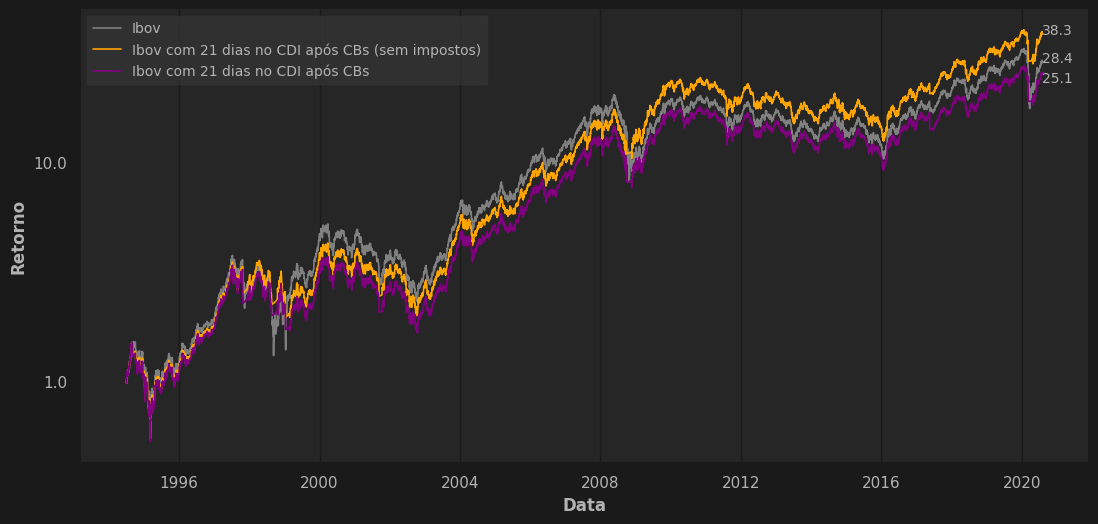

In [ ]:
fig, ax = plt.subplots(figsize=(13,6), dpi= 100)
ax.plot(df_idx_day.ReturnNoFees, c='grey', alpha=1, linewidth=1.2, label='Ibov')
ax.plot(df_calc.ReturnNoTax_SkipDaysAfterCB, c='orange', alpha=1, linewidth=1.2,
        label='Ibov com ' + str(skipped_days) + ' dia' + ('s' if skipped_days > 1 else '') +
        ' no CDI após CBs (sem impostos)')
ax.plot(df_calc.Return_SkipDaysAfterCB, c='purple', alpha=1, linewidth=1.2,
        label='Ibov com ' + str(skipped_days) + ' dia' + ('s' if skipped_days > 1 else '') +
        ' no CDI após CBs')
ax.legend(loc='upper left', fontsize='small', fancybox=False, facecolor='0.2', edgecolor='0.2')
ax.text(df_idx_day.index[-1], df_idx_day.ReturnNoFees[-1],
        r'%.1f' % df_idx_day.ReturnNoFees[-1], fontsize='small')
ax.text(df_calc.index[-1], df_calc.ReturnNoTax_SkipDaysAfterCB[-1],
        r'%.1f' % df_calc.ReturnNoTax_SkipDaysAfterCB[-1], fontsize='small')
ax.text(df_calc.index[-1], df_calc.Return_SkipDaysAfterCB[-1]-2,
        r'%.1f' % df_calc.Return_SkipDaysAfterCB[-1], fontsize='small')
plt.yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Data', fontweight='bold')
ax.set_ylabel('Retorno', fontweight='bold')
ax.grid(axis='y')

Text(0.5, 0, 'Data')

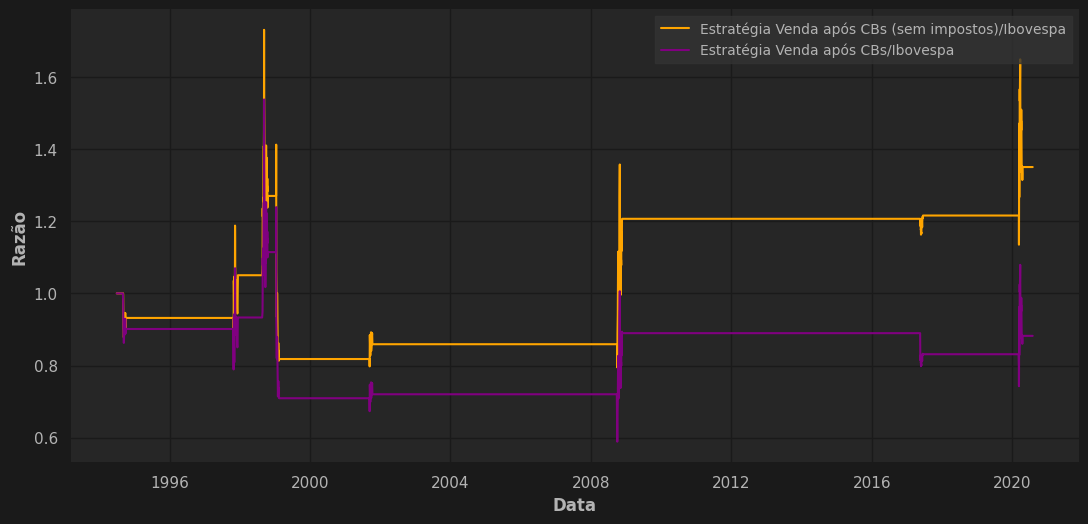

In [ ]:
fig2, ax2 = plt.subplots(figsize=(13,6), dpi= 100)
ax2.plot(df_calc.ReturnNoTax_SkipDaysAfterCB / df_idx_day.Return, c='orange', alpha=1,
         label='Estratégia Venda após CBs (sem impostos)/Ibovespa')
ax2.plot(df_calc.Return_SkipDaysAfterCB / df_idx_day.Return, c='purple', alpha=1,
         label='Estratégia Venda após CBs/Ibovespa')
ax2.legend(loc='upper right', fontsize='small', fancybox=False, facecolor='0.2', edgecolor='0.2')
ax2.set_ylabel('Razão', fontweight='bold')
ax2.set_xlabel('Data', fontweight='bold')